### Basic usage

In [56]:
from pathlib import Path
import numpy as np
import importlib
import sea_ingest
import pandas as pd

from datetime import datetime, timezone
from matplotlib import pyplot as plt

sea_ingest = importlib.reload(sea_ingest)
from sea_ingest import seamf

seamf = importlib.reload(seamf)

data_path = Path("data")
plt.style.use("report.mplstyle")

## Load a file

In [48]:
fname = "HUT_Data_2023-09-25_11557"
dfs = sea_ingest.read_seamf(
    data_path / f"{fname}.sigmf", localize=False
)

## Whole-Band PSD Plot

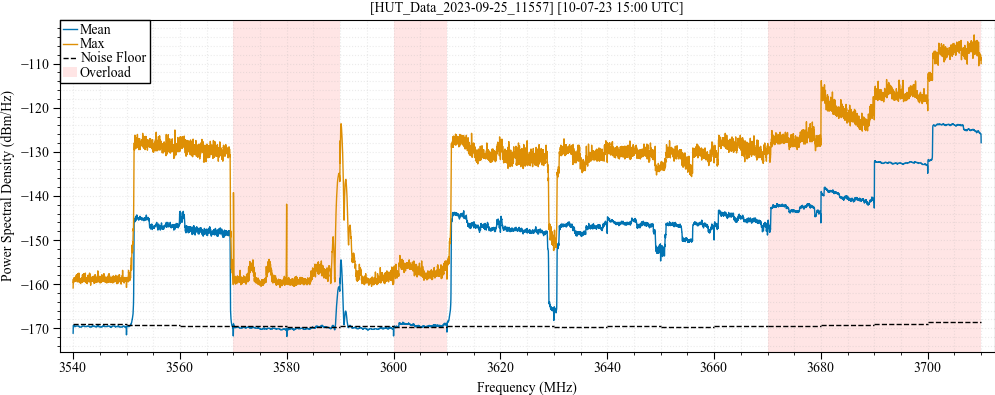

In [68]:
# Get noise floor values
ktb = (
    (dfs["channel_metadata"].cal_temperature_degC + 273.15)
    .astype(np.float64)
    .mul(1.380649e-23)
    .apply(np.log10)
    .mul(10.0)
    .add(30.0)
    .add(dfs["channel_metadata"].cal_noise_figure_dB)
).droplevel("datetime")

noise_floor_minfreqs = []
noise_floor_maxfreqs = []
noise_floor_dBmpHz = []

# Construct for plotting
for cf, nf in ktb.items():
    noise_floor_minfreqs.append((cf - 5e6) / 1e6)
    noise_floor_maxfreqs.append((cf + 5e6) / 1e6)
    noise_floor_dBmpHz.append(nf)

# join all channel PSD results for plotting
# and construct combined frequency axis
full_band_freqs = []
full_band_mean_psd = []
full_band_max_psd = []
for i, ch_psd in dfs["psd"].droplevel("datetime").iterrows():
    if i[1] == "max":
        full_band_freqs.extend((ch_psd.index + i[0]).tolist())
        full_band_max_psd.extend(ch_psd.tolist())
    elif i[1] == "mean":
        full_band_mean_psd.extend(ch_psd.tolist())
full_band_freqs = np.array(full_band_freqs) / 1e6  # Frequencies in MHz

# Plot the results
fig, ax = plt.subplots(figsize=(10, 4))
# Plot PSD
ax.plot(full_band_freqs, full_band_mean_psd, label="Mean")
ax.plot(full_band_freqs, full_band_max_psd, label="Max")
ax.set_xlim(full_band_freqs[0] - 2.5, full_band_freqs[-1] + 2.5)
# Plot noise floors
ax.hlines(
    noise_floor_dBmpHz,
    noise_floor_minfreqs,
    noise_floor_maxfreqs,
    colors="k",
    linestyles="dashed",
    label="Noise Floor",
)
# Shade overloaded channels red
first_ol = True
for cf, ol in dfs["channel_metadata"].overload.droplevel("datetime").items():
    if ol:
        if first_ol:
            ax.axvspan((cf / 1e6) - 5, (cf / 1e6) + 5, color="r", alpha=0.1, lw=0, label="Overload")
            first_ol = False  # only label the shaded regions once
        else:
            ax.axvspan((cf / 1e6) - 5, (cf / 1e6) + 5, color="r", alpha=0.1, lw=0)
ax.minorticks_on()
ax.grid(True, which="both", alpha=0.25)
ax.set_ylabel("Power Spectral Density (dBm/Hz)")
ax.set_xlabel("Frequency (MHz)")
sweep_time = (
    datetime.fromisoformat(dfs["sweep_metadata"].datetime[0][:-1])
    .strftime("%m-%d-%y %H:%M UTC")
)
ax.set_title(f"[{fname}] [{sweep_time}]")
ax.legend()

# Configure here to zoom on a channel or channels:
# ax.set_xlim(3540, 3560)

plt.show()

## APD Plotting

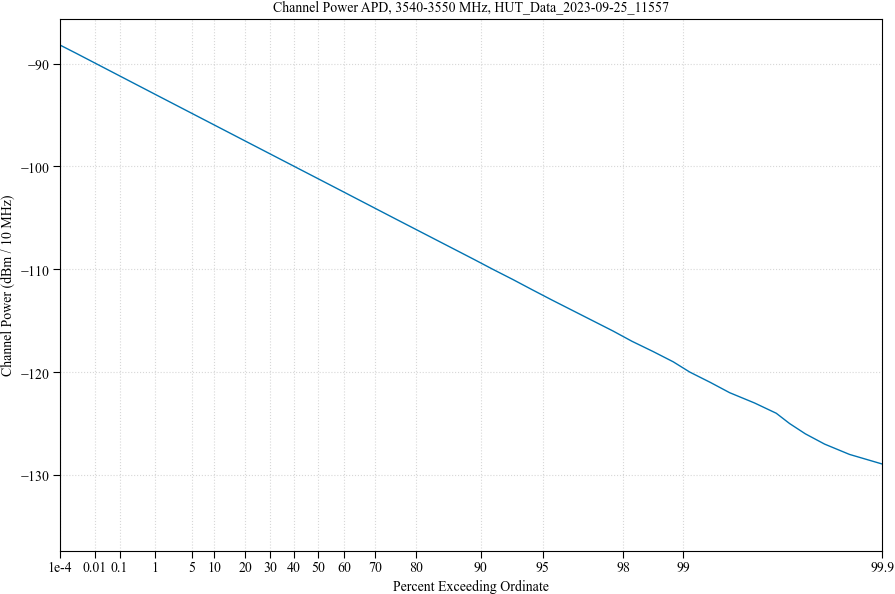

In [73]:
frequency = 3545  # MHz
apd = dfs["apd"].loc(axis=0)[:, frequency*1e6]

# This just shows that the index/data are reversed from what would be expected

# one solution is to create a new series, swapping the axis for the channel data:
apd = pd.Series(apd.columns.values, index=apd.values[0])

# plot setup: define x-axis ticks
xtick_labels = [
    "1e-4", "0.01", "0.1", "1", "5", "10", "20", "30", "40",
    "50", "60", "70", "80", "90", "95", "98", "99", "99.9",
]
ptick_values = np.array([float(x) / 100. for x in xtick_labels])
x_origin = 10.0 * np.log10(-np.log(ptick_values[0]))
# Map p value ticks to x values
xtick = x_origin - 10.0 * np.log10(-np.log(ptick_values))

# Map p values to x axis, dealing with NaNs
p = np.where(apd.index != 0, apd.index, np.nan)
logp = np.where(np.log(p) != 0, np.log(p), np.nan)
x = x_origin - 10.0 * np.log10(-logp)

# plot
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(x, apd.values)
ax.set_xlabel("Percent Exceeding Ordinate")
ax.set_xticks(xtick, xtick_labels)#, fontsize=8)
ax.set_xlim(xtick.min(), xtick.max())
ax.grid(True, "minor", "y", alpha=0.75)
ax.grid(True, "major", "both", alpha=0.5)
ax.set_ylabel("Channel Power (dBm / 10 MHz)")
ax.set_title(f"Channel Power APD, {frequency-5}-{frequency+5} MHz [{fname}]")
plt.show()

## PFP Plots

<Axes: xlabel='Frame time elapsed (s)', ylabel='PFP (dBm/10MHz)'>

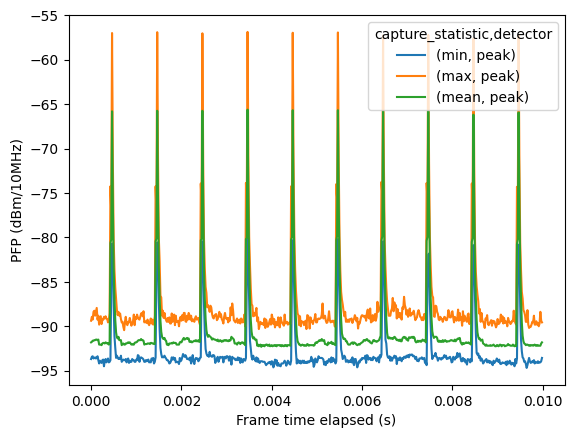

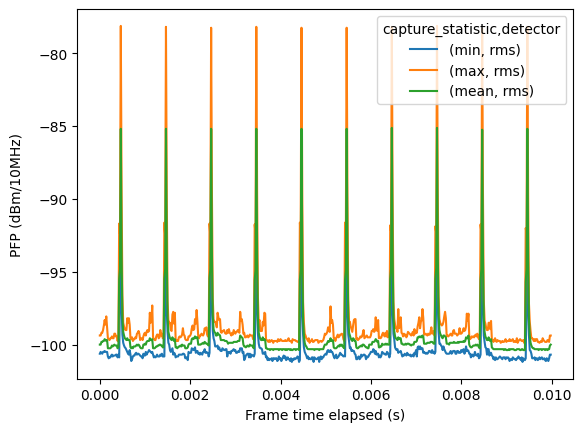

In [47]:
# Select a channel by its center frequency (MHz) here
cf = 3595

fig, ax = plt.subplots()
(
    dfs6["pfp"]
    .loc(axis=0)[:, cf * 1e6, :, "peak"]
    .droplevel(["datetime", "frequency"])
    .T.plot(ax=ax, ylabel="PFP (dBm/10MHz)")
)

fig, ax = plt.subplots()
(
    dfs6["pfp"]
    .loc(axis=0)[:, cf * 1e6, :, "rms"]
    .droplevel(["datetime", "frequency"])
    .T.plot(ax=ax, ylabel="PFP (dBm/10MHz)")
)